In [2]:
!pip install tqdm

In [75]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
import gc
warnings.filterwarnings('ignore')
%matplotlib inline

In [61]:
data = pd.read_csv('./01F0467N01F0413N.csv')

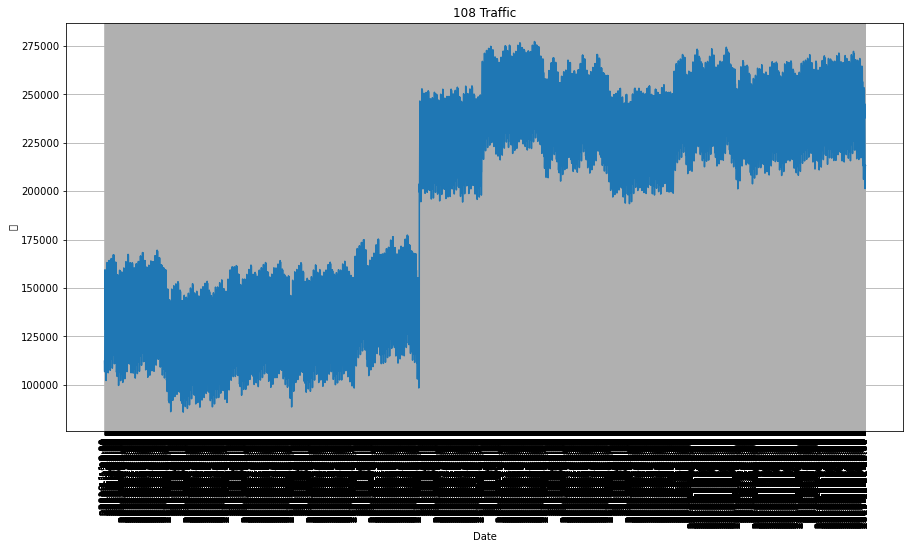

In [6]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['Date'], data['Traffic'])
plt.title('108 Traffic')
plt.ylabel('輛')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

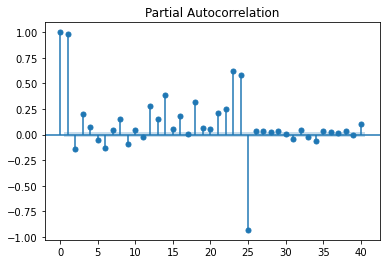

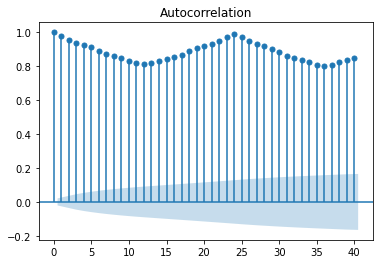

In [7]:
plot_pacf(data['Traffic']);
plot_acf(data['Traffic']);

In [8]:
ad_fuller_result = adfuller(data['Traffic'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.3708094540644489
p-value: 0.5961876977338231


In [62]:
data['Traffic'] = np.log(data['Traffic'])
data['Traffic'] = data['Traffic'].diff()
data = data.drop(data.index[0])

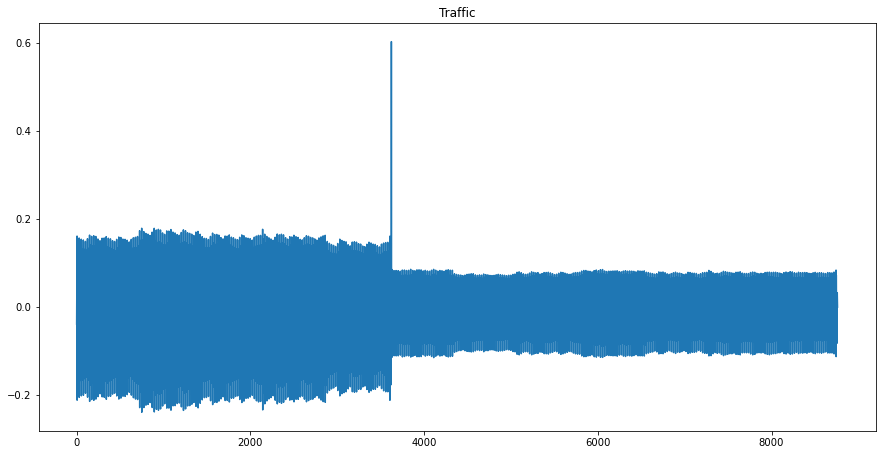

In [18]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['Traffic'])
plt.title("Traffic")
plt.show()

In [63]:
# Seasonal differencing
data['Traffic'] = data['Traffic'].diff(24)
data = data.drop(index=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]).reset_index(drop=True)

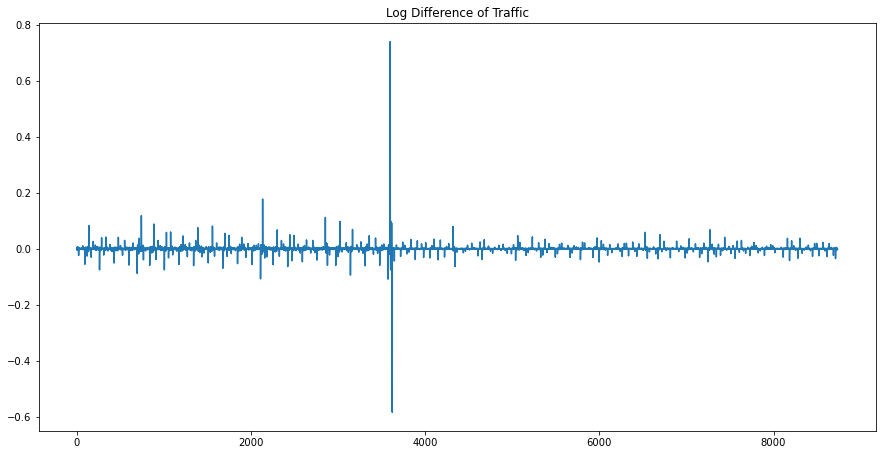

In [64]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['Traffic'])
plt.title("Log Difference of Traffic")
plt.show()

In [66]:
ad_fuller_result = adfuller(data['Traffic'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -24.187254982014686
p-value: 0.0


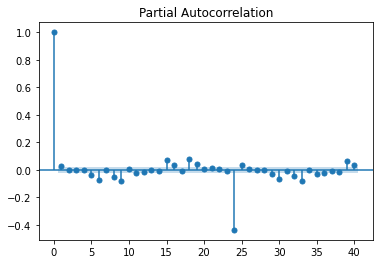

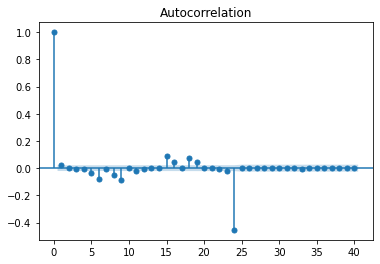

In [67]:
plot_pacf(data['Traffic']);
plot_acf(data['Traffic']);

In [68]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [69]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [70]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data['Traffic'])
result_df

,"(p,q)x(P,Q)",AIC
0,"(1, 2, 3, 3)",-52958.067756
1,"(2, 2, 3, 3)",-52891.019000
2,"(3, 3, 3, 3)",-52832.618515
3,"(0, 3, 3, 3)",-52732.301861
4,"(1, 3, 3, 3)",-52689.180532
...,...,...
243,"(3, 0, 0, 0)",-43446.924201
244,"(2, 0, 0, 0)",-43317.893751
245,"(1, 0, 0, 0)",-42529.767407
246,"(0, 0, 1, 0)",-42478.245269


In [71]:
best_model = SARIMAX(data['Traffic'], order=(1, 1, 2), seasonal_order=(3, 1, 3, 24)).fit(dis=-1)
print(best_model.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                    Traffic   No. Observations:                 8735
Model:             SARIMAX(1, 1, 2)x(3, 1, [1, 2, 3], 24)   Log Likelihood               27004.314
Date:                                    Tue, 04 Aug 2020   AIC                         -53988.628
Time:                                            11:08:54   BIC                         -53917.906
Sample:                                                 0   HQIC                        -53964.524
                                                   - 8735                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8543      0.018    -46.426      0

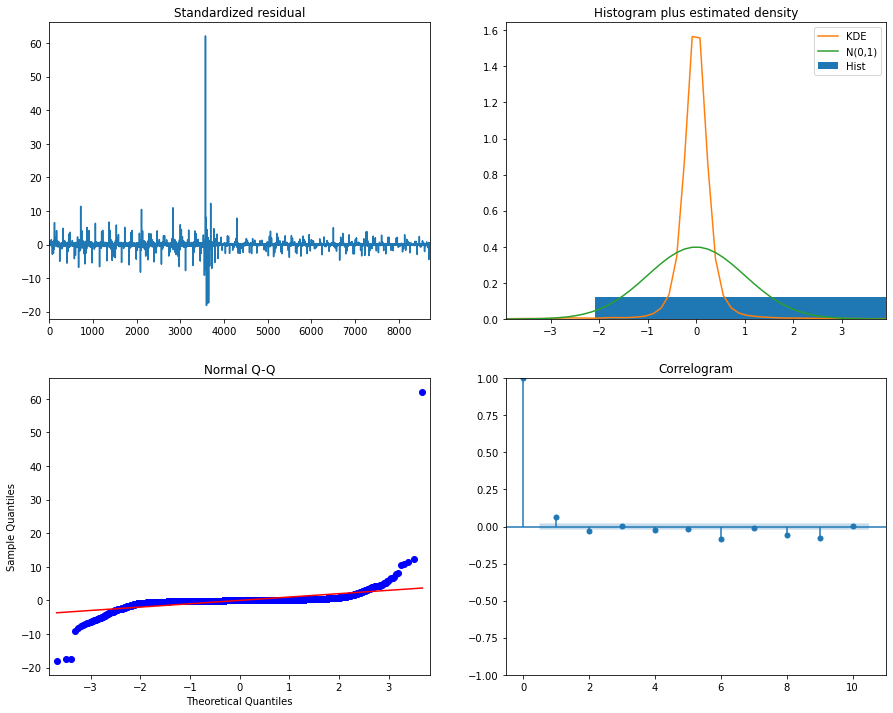

In [72]:
best_model.plot_diagnostics(figsize=(15,12));

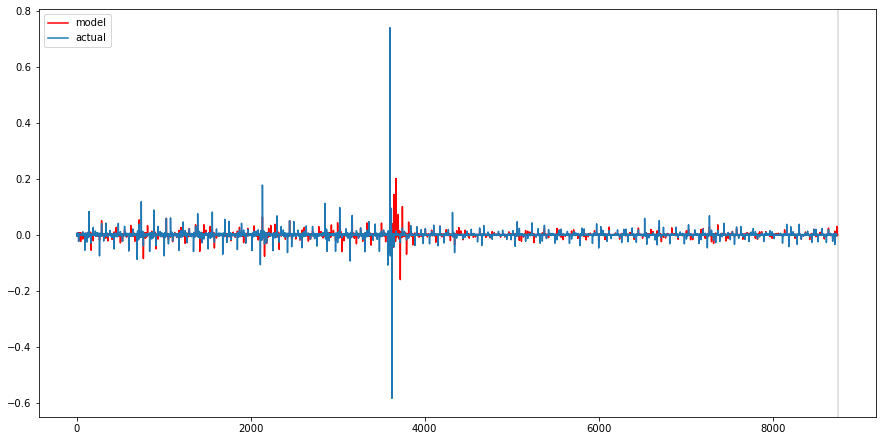

In [73]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 8)
forecast = data['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['Traffic'], label='actual')
plt.legend()
plt.show()

In [76]:
gc.collect()

664631